<a href="https://colab.research.google.com/github/aliyaaliyal/mesin-learning/blob/main/classifikasi_gambar_menggunakan_tensorflow_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diagnostics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import dask.bag as bag
import dask.array as da
from dask.diagnostics import ProgressBar
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from keras.preprocessing import image
import keras
from tensorflow.keras.utils import load_img, img_to_array 

In [ ]:
bunga = os.path.join('/content/drive/MyDrive/ML/bunga')
anggrek = os.path.join('/content/drive/MyDrive/ML/bunga/anggrek')
kenanga = os.path.join('/content/drive/MyDrive/ML/bunga/kenanga')
matahari = os.path.join('/content/drive/MyDrive/ML/bunga/matahari')
mawar = os.path.join('/content/drive/MyDrive/ML/bunga/mawar')
melati = os.path.join('/content/drive/MyDrive/ML/bunga/melati')

print(os.listdir(bunga))

['mawar', 'melati', 'matahari', 'kenanga', 'anggrek']


In [ ]:
daftar_bunga = os.listdir(bunga)

In [ ]:
daftar_bunga

['mawar', 'melati', 'matahari', 'kenanga', 'anggrek']

In [ ]:
total = 0

for x in daftar_bunga:
  dir = os.path.join(bunga, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  total = total + y
  
  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal :', total)

mawar: 367
- (100, 100)
- (100, 100)
- (100, 100)
- (100, 100)
---------------
melati: 400
- (225, 225)
- (221, 228)
- (225, 225)
- (100, 100)
---------------
matahari: 518
- (275, 183)
- (100, 100)
- (300, 168)
- (100, 100)
---------------
kenanga: 483
- (100, 100)
- (100, 100)
- (275, 183)
- (254, 199)
---------------
anggrek: 531
- (194, 259)
- (100, 100)
- (225, 225)
- (225, 225)
---------------

Total : 2299


In [ ]:
number_classes = {
'Anggrek': len(os.listdir(anggrek)),
'Kenanga': len(os.listdir(kenanga)),
'Matahari': len(os.listdir(matahari)),
'Mawar': len(os.listdir(mawar)),
'Melati': len(os.listdir(melati))}

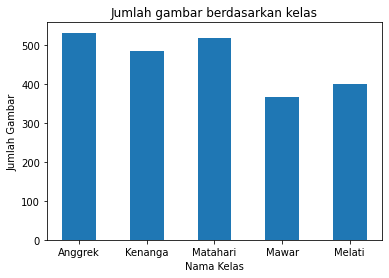

In [ ]:
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Jumlah gambar berdasarkan kelas");
plt.xlabel('Nama Kelas');
plt.ylabel('Jumlah Gambar');

In [ ]:
directories = {'anggrek': '/content/drive/MyDrive/ML/bunga/anggrek/',
'kenanga': '/content/drive/MyDrive/ML/bunga/kenanga/',
'matahari': '/content/drive/MyDrive/ML/bunga/matahari/',
'mawar': '/content/drive/MyDrive/ML/bunga/mawar/',
'melati': '/content/drive/MyDrive/ML/bunga/melati/'}

def get_dims(file):
  '''Returns dimenstions for an RBG image'''
  im = Image.open(file)
  arr = np.array(im)
  if(len(arr.shape) >2):
     h,w,d = arr.shape
  else:
     h,w = arr.shape
  return h,w

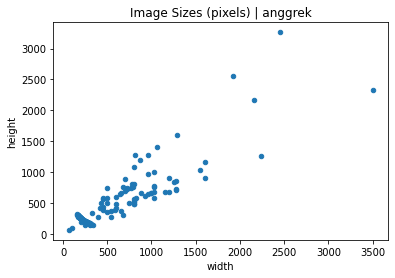

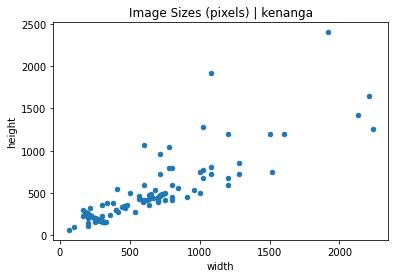

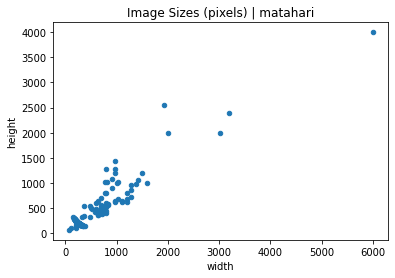

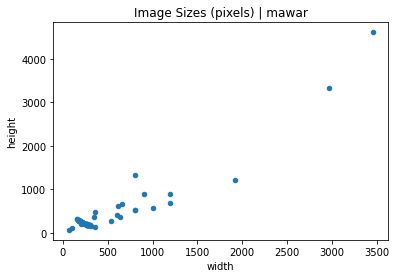

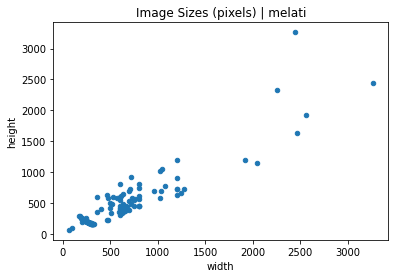

In [ ]:
for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = bag.from_sequence(filelist).map(get_dims)
  dims = dims.compute()
  dim_df = pd.DataFrame(dims, columns=['height', 'width'])
  sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
  sizes.plot.scatter(x='width', y='height');
  plt.title('Image Sizes (pixels) | {}'.format(n))

<function matplotlib.pyplot.show(*args, **kw)>

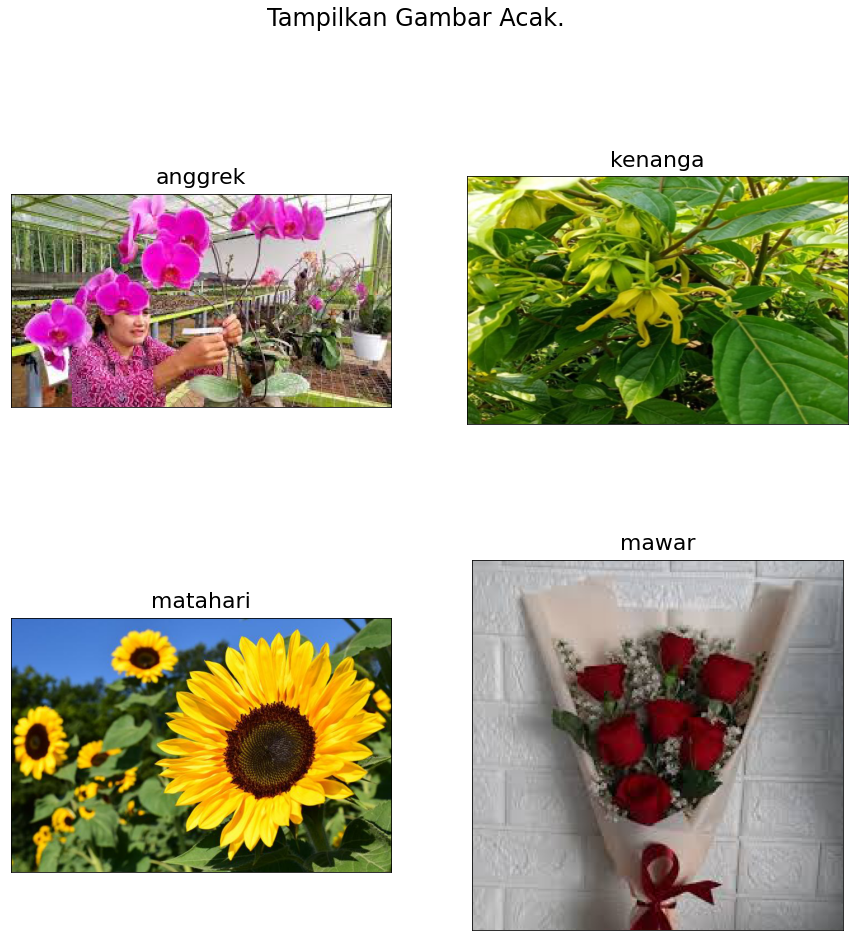

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle("Tampilkan Gambar Acak.", fontsize=24)
bunga_sorted = sorted(daftar_bunga)
bunga_id = 0
for i in range(2):
  for j in range(2):
    try:
      bunga_selected = bunga_sorted[bunga_id] 
      bunga_id += 1
    except:
      break
    if bunga_selected == '.TEMP':
        continue
    bunga_selected_images = os.listdir(os.path.join(bunga, bunga_selected))
    bunga_selected_random = np.random.choice(bunga_selected_images)
    img = plt.imread(os.path.join(bunga, bunga_selected, bunga_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(bunga_selected, pad=10, fontsize=22)
    
plt.setp(ax, xticks=[],yticks=[])
plt.show

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   
)

In [ ]:
batch_size = 256

data_train = train_datagen.flow_from_directory(
    bunga,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

data_val = train_datagen.flow_from_directory(
    bunga, 
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 1841 images belonging to 5 classes.
Found 458 images belonging to 5 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85 and logs.get('val_accuracy')>0.85):
      print("\nAccuracy above 85%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(data_train, 
                    epochs = 40, 
                    steps_per_epoch = data_train.samples // batch_size,
                    validation_data = data_val, 
                    validation_steps = data_val.samples // batch_size,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/40
7/7 [==============================] - 35s 3s/step - loss: 1.4935 - accuracy: 0.3281 - val_loss: 1.0427 - val_accuracy: 0.6523
Epoch 2/40
7/7 [==============================] - 23s 4s/step - loss: 0.9998 - accuracy: 0.6025 - val_loss: 0.8241 - val_accuracy: 0.6914
Epoch 3/40
7/7 [==============================] - 23s 4s/step - loss: 0.7998 - accuracy: 0.7161 - val_loss: 0.7820 - val_accuracy: 0.6992
Epoch 4/40
7/7 [==============================] - 24s 3s/step - loss: 0.6945 - accuracy: 0.7455 - val_loss: 0.7543 - val_accuracy: 0.7109
Epoch 5/40
7/7 [==============================] - 22s 3s/step - loss: 0.6421 - accuracy: 0.7811 - val_loss: 0.7182 - val_accuracy: 0.7422
Epoch 6/40
7/7 [==============================] - 23s 3s/step - loss: 0.6836 - accuracy: 0.7571 - val_loss: 0.7552 - val_accuracy: 0.7344
Epoch 7/40
7/7 [==============================] - 23s 3s/step - loss: 0.6628 - accuracy: 0.7645 - val_loss: 0.5806 - val_accuracy: 0.7734
Epoch 8/40
7/7 [==================

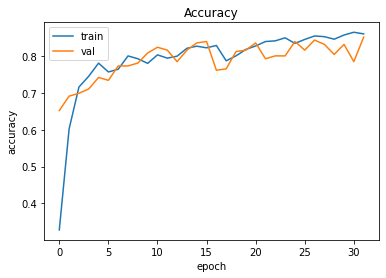

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

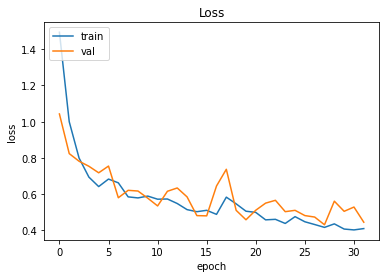

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

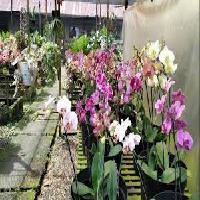

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
path0="/content/drive/MyDrive/ML/bunga/anggrek/gb2236.jpg"
load_img(path0,target_size=(200,200))

In [ ]:
image=load_img(path0,target_size=(150,150))
image=img_to_array(image) 
image=image/255.0
prediction_image=np.expand_dims(image, axis=0)
print(prediction_image.shape)

(1, 150, 150, 3)


In [ ]:
prediction=model.predict(prediction_image)
value=np.argmax(prediction)
if value == 0:
   label = 'anggrek'
elif value == 1:
   label = 'kenanga'
elif value == 2:
   label = 'matahari'
elif value == 3:
   label = 'mawar'
elif value == 4:
   label = 'melati'
else:
   label = 'tidak tahu ini bunga apa'
print("Prediksinya adalah ini bunga {}.".format(label))

1/1 [==============================] - 0s 234ms/step
Prediksinya adalah ini bunga anggrek.


In [ ]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])
  value = np.argmax(model.predict(im_input))

  if value == 0:
    label = 'anggrek'
  elif value == 1:
    label = 'kenanga'
  elif value == 2:
    label = 'matahari'
  elif value == 3:
    label = 'mawar'
  elif value == 4:
    label = 'melati'
  else:
    label = 'tidak tahu ini bunga apa'
  print("Prediksinya adalah ini bunga {}.".format(label))

Saving gb215.jpeg to gb215.jpeg
1/1 [==============================] - 0s 17ms/step
Prediksinya adalah ini bunga matahari.


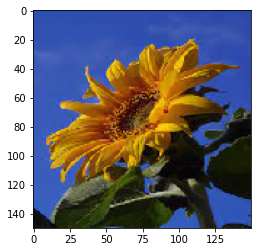

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = tf.keras.utils.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

predict_image(img)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root 13902688 Dec  7 15:04 model.tflite
